## Recommendation (collaborative filtering) example

In [4]:
# pyspark specific imports
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

# other python imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pyspark.sql.functions as F

In [6]:
sc

<SparkContext master=local[*] appName=PySparkShell>

### Load data


GroupLens Research has collected and made available rating data sets from the MovieLens web site. The data sets were collected over various periods of time, depending on the size of the set. They can be found here.

In our case, we will use the latest datasets:

* Small: 100,000 ratings and 2,488 tag applications applied to 8,570 movies by 706 users by 4/2015.
* Full: 21,000,000 ratings and 470,000 tag applications applied to 27,000 movies by 230,000 users by 4/2015.

Data was previously downloaded to master and sent to S3 bucket 

In [7]:
local_setup = False
dsets_paths = dict()

if local_setup:
    dsets_paths['ratings'] = 'ratings.csv'
    dsets_paths['movies'] =  'movies.csv'
else:
    dsets_paths['ratings'] = "s3a://jalg-data/data/public-data-sets/movielens/ml-latest-small/ratings.csv"
    #dsets_paths['ratings'] "s3a://jalg-data/data/public-data-sets/movielens/ml-latest/ratings.csv"
    dsets_paths['movies'] = "s3a://jalg-data/data/public-data-sets/movielens/ml-latest-small/movies.csv"
    #dsets_paths['movies'] ="s3a://jalg-data/data/public-data-sets/movielens/ml-latest/movies.csv"
# load ratings
ratings = spark.read.option("sep", ",")\
            .option("header", "true")\
            .csv(dsets_paths['ratings']
                 , inferSchema=True)#.limit(30000)
ratings = ratings.cache()

In [8]:
print(ratings.show(3))
print(ratings.describe(["userId", "movieId", "rating", "timestamp"]).show())
print('unique users', ratings.select('userId').dropDuplicates().count())
print('unique items', ratings.select('movieId').dropDuplicates().count())

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
+------+-------+------+---------+
only showing top 3 rows

None
+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------

In [9]:
# load movie titles
movies = spark.read.option("sep", ",")\
            .option("header", "true")\
            .csv( dsets_paths['movies']
                 , inferSchema=True)
movies = movies.cache()

In [10]:
# print first n movies
n=2
movies.head(n)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy')]

## Personalized recommendations with  Alternating Least Squares (ALS)¶

Build the recommendation model using Spark  Collaborative Filtering implementation 
using Alternating Least Squares (ALS)  on the training data.  
The movies data set already has the necessary format (UserId, MovieId, Rating) to feed the ALS in order to build the recommender system. 

So we proceed to split the data set in to a train and test subsets.

In [11]:
# Split on train and test
(training, test) = ratings.randomSplit([0.8, 0.2])

### Train matrix factorization model¶

Then train using the train set.

### Model Optimization
The ALS model can be interpreted as  users evaluations being the consequence of preference hidden factors on a lower space (lower than the users by movies matrix rank). So the model learns those factors by gradually learning its weights. To tweak it, the next hyper parameters can be modified.

Sources: [SparkALS](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html). and [this implementation](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
).


* __rank__ (defaults to 10): the number of latent factors in the model, or equivalently, the number of columns k in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank.

* __iterations__  (defaults to 10): the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* __regParam___ (defaulst to 1.0): a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.


In [22]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
# K and lambda values were obtained with a sampling subset made on other notebook

evaluations = []
ranks = [6, 10, 20, 40,  100 ] #, 150,200 5, 7, 
lambdas = [1, 0.15, .015, .0015, .00015 ] #10, 1.0, .01, .001, .0001
best_model = dict()
best_test_performance = None  
best_model = None

stime = time.time()
counter = 1
for rank in ranks: 
    for lambda_ in lambdas: # lambda_ because lambda is a reserved word
        ncombinations = len(ranks)*len(lambdas)
        if ((counter % len(ranks)*len(lambdas)//5) == 0) or (counter in [1, ncombinations] ): #Limit the prints to six
            print("Train %d of %d models with rank=%d lambda_=%f" % (counter, total_models, rank, lambda_))
        # with each combination of params, we should run multiple times and get avg
        # for simple, we only run one time.

        model = ALS(regParam=lambda_, rank=rank, userCol="userId", itemCol="movieId", ratingCol="rating"
                 , maxIter=20
                 , seed = 4321
                 , coldStartStrategy="drop"  # 'drop' to ensure we don't get NaN evaluation metrics
                 , numUserBlocks=10
                 , numItemBlocks=10)
        model = model.fit(training)

        predictions = model.transform(training)
        # Evaluate the model by computing the RMSE on train and test datasets
        predictions = model.transform(training)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
        rmse_train = evaluator.evaluate(predictions)
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
        rmse_test = evaluator.evaluate(predictions)
        #print(best_test_performance, rmse_test)
         
        best_test_performance = rmse_test if not best_test_performance else min([rmse_test, best_test_performance])
        if (best_test_performance == rmse_test): #Update best model
            best_model = model.copy()
        #print('best_perf', best_test_performance)
        
        evaluations.append(((rank, lambda_), rmse_train, rmse_test))
        counter +=1

etime = time.time()

Train 1 of 25 models with rank=6 lambda_=1.000000
Train 5 of 25 models with rank=6 lambda_=0.000150
Train 10 of 25 models with rank=10 lambda_=0.000150
Train 15 of 25 models with rank=20 lambda_=0.000150
Train 20 of 25 models with rank=40 lambda_=0.000150
Train 25 of 25 models with rank=100 lambda_=0.000150


In [23]:
etime = time.time()
print('Elapsed time: %.2f mins.' % ((etime-stime)/60))


Elapsed time: 6.67 mins.


In [59]:
performance_df = pd.DataFrame(  {'rank': [e[0][0] for e in evaluations]
                              , 'lambda': [e[0][1] for e in evaluations]
                              , 'train_error': [e[1] for e in evaluations]
                              , 'test_error': [e[2] for e in evaluations]
                              })
performance_df.sort_values(by='test_error').head(8)

,rank,lambda,train_error,test_error
11,20,0.150,0.604214,0.869655
16,40,0.150,0.594258,0.870355
6,10,0.150,0.632943,0.870623
21,100,0.150,0.592612,0.870687
1,6,0.150,0.664213,0.872047
2,6,0.015,0.557275,1.023516
7,10,0.015,0.459796,1.090942
12,20,0.015,0.300401,1.172729


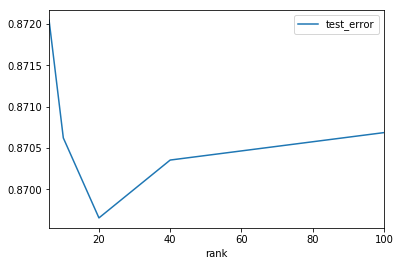

In [25]:
# Let's pot all rank values fixing lambda on it's best performance value 
fig, ax = plt.subplots()
performance_df.loc[performance_df['lambda'] == 0.15,:].sort_values(by='rank')\
    .set_index('rank')[['test_error']].plot(ax=ax)
plt.show()

In [26]:
performance_df.loc[performance_df.train_error==0.15,:]

,rank,lambda,train_error,test_error


In [27]:
model = best_model
best_model.rank

20

## Make Recommendations¶

With the trained model we can make some recommendations. 


Before, that let’s explore the test set. We can see that every user has evaluated a different number of movies. 

In [28]:
def explore_user(uID):
    userRecs(uID)

In [29]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
# movieRecs = model.recommendForAllItems(10)
userRecs.cache()

DataFrame[userId: int, recommendations: array<struct<movieId:int,rating:float>>]

In [30]:
def movie_names(mid):
    #print(type(movies.where(col("movieId") == mid).select(col("title")).collect()))
    return movies.where(col("movieId") == mid).select(col("title")).collect()[0][0]

def movie_genres(mid):
    #print(type(movies.where(col("movieId") == mid).select(col("title")).collect()))
    return movies.where(col("movieId") == mid).select(col("genres")).collect()[0][0]

In [31]:
# Lets explore some valid userId values
training.groupBy('userId')\
        .agg(
         F.count(F.lit(1)).alias("Num Of Records")
        )\
        .show(5)

+------+--------------+
|userId|Num Of Records|
+------+--------------+
|   148|            35|
|   463|            24|
|   471|            23|
|   496|            25|
|   243|            29|
+------+--------------+
only showing top 5 rows



In [32]:
test.show(5)
user2test = test.select('userID').take(1)[0]['userID']
user2test

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     70|   3.0|964982400|
|     1|    110|   4.0|964982176|
|     1|    157|   5.0|964984100|
+------+-------+------+---------+
only showing top 5 rows



1


Let’s see which movies a user has seen and which are the ten first recommendations made by the model.

In [33]:
uID = user2test

training_user = training.where(training.userId == uID).select("movieId", "rating").collect()
print('Training set for user %d' % uID)
for i,movie in enumerate(training_user):
    #rating = training_user.where(training_user.movieId == movie.movieId).select("rating").collect()
    print('\t %s. %s %d ' % (movie_names(movie.movieId), movie_genres(movie.movieId), movie.rating))
print('') # skip line

reco_users = userRecs.where(userRecs.userId == uID).select("recommendations.movieId", "recommendations.rating").collect()[0]
print('Recommendations for user %d' % uID)
for i,mid in enumerate(reco_users[0]):
    print('\t %d. %s (%s) (predicted rating: %.3f)' % (i+1,movie_names(mid),movie_genres(mid), reco_users[1][i]))
    

Training set for user 1
	 Toy Story (1995). Adventure|Animation|Children|Comedy|Fantasy 4 
	 Seven (a.k.a. Se7en) (1995). Mystery|Thriller 5 
	 Usual Suspects, The (1995). Crime|Mystery|Thriller 5 
	 Bottle Rocket (1996). Adventure|Comedy|Crime|Romance 5 
	 Rob Roy (1995). Action|Drama|Romance|War 5 
	 Desperado (1995). Action|Romance|Western 5 
	 Billy Madison (1995). Comedy 5 
	 Clerks (1994). Comedy 3 
	 Dumb & Dumber (Dumb and Dumber) (1994). Adventure|Comedy 5 
	 Star Wars: Episode IV - A New Hope (1977). Action|Adventure|Sci-Fi 5 
	 Pulp Fiction (1994). Comedy|Crime|Drama|Thriller 3 
	 Tommy Boy (1995). Comedy 5 
	 Forrest Gump (1994). Comedy|Drama|Romance|War 4 
	 Jungle Book, The (1994). Adventure|Children|Romance 5 
	 Mask, The (1994). Action|Comedy|Crime|Fantasy 4 
	 Blown Away (1994). Action|Thriller 3 
	 Dazed and Confused (1993). Comedy 4 
	 Fugitive, The (1993). Thriller 5 
	 Jurassic Park (1993). Action|Adventure|Sci-Fi|Thriller 4 
	 Mrs. Doubtfire (1993). Comedy|Drama 3

	 Big (1988). Comedy|Drama|Fantasy|Romance 4 
	 American Beauty (1999). Drama|Romance 5 
	 Excalibur (1981). Adventure|Fantasy 5 
	 Gulliver's Travels (1939). Adventure|Animation|Children 5 
	 Total Recall (1990). Action|Adventure|Sci-Fi|Thriller 4 
	 Dirty Dozen, The (1967). Action|Drama|War 5 
	 Goldfinger (1964). Action|Adventure|Thriller 5 
	 From Russia with Love (1963). Action|Adventure|Thriller 5 
	 Dr. No (1962). Action|Adventure|Thriller 5 
	 RoboCop (1987). Action|Crime|Drama|Sci-Fi|Thriller 4 
	 Who Framed Roger Rabbit? (1988). Adventure|Animation|Children|Comedy|Crime|Fantasy|Mystery 5 
	 Live and Let Die (1973). Action|Adventure|Thriller 5 
	 Spaceballs (1987). Comedy|Sci-Fi 5 
	 Robin Hood (1973). Adventure|Animation|Children|Comedy|Musical 5 
	 Dogma (1999). Adventure|Comedy|Fantasy 5 
	 Messenger: The Story of Joan of Arc, The (1999). Drama|War 5 
	 Longest Day, The (1962). Action|Drama|War 4 
	 Green Mile, The (1999). Crime|Drama 5 
	 Easy Rider (1969). Adventure|Drama

## Making users segments
  

Let's get client groups on the reduced projection of the movie space. This will give groups of users with similar movie preferences.

In [34]:
# Fist explore the model schema. 
model.userFactors.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



In [35]:
model.userFactors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.8816551, -0.3...|
| 20|[0.16113001, -0.4...|
| 30|[-0.1453728, -0.1...|
| 40|[0.057068627, -0....|
| 50|[0.062313825, -0....|
| 60|[-0.13638602, -0....|
| 70|[0.005427462, -0....|
| 80|[-0.17843084, -0....|
| 90|[0.26866132, -0.1...|
|100|[-0.17184384, -0....|
|110|[0.025727633, -0....|
|120|[0.072504215, 0.1...|
|130|[-0.49154824, -0....|
|140|[-0.049246304, -0...|
|150|[-0.08004944, -0....|
|160|[0.016338939, -0....|
|170|[0.04900046, -0.1...|
|180|[-0.26558352, -0....|
|190|[0.13631311, -0.4...|
|200|[-0.267832, -0.47...|
+---+--------------------+
only showing top 20 rows



In [36]:
# To fit k means we need to transform the struct column (array of floats)
# to make it a VectorUDT() fittable on k means model
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
userFactors = model.userFactors.select("id", to_vector("features").alias("features"))
userFactors.show(2)
userFactors.printSchema()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.8816550970077...|
| 20|[0.16113001108169...|
+---+--------------------+
only showing top 2 rows

root
 |-- id: integer (nullable = false)
 |-- features: vector (nullable = true)



###  KMeans clustering

In [37]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# from pyspark.ml.evaluation import ClusteringEvaluator #←Available from Spark2.4 otherwisee
# "cannnot import name Clustering Evaluator"

distances = []
K = [i for i in range(2,10,2)]
kmeans_metric = 'silhouette' #wssse
# Trains a k-means model.
for k in K: #
    kmeans = KMeans().setK(k).setSeed(123)
    cluster_model = kmeans.fit(userFactors)
    if kmeans_metric == 'silhouette':
        # Evaluate clustering by computing Silhouette score
        evaluator = ClusteringEvaluator()
        predictions = cluster_model.transform(userFactors)
        cluster_metric = evaluator.evaluate(predictions)
    elif kmeans_metric=='wssse':
        # Evaluate clustering by computing Within Set Sum of Squared Errors.
        cluster_metric = cluster_model.computeCost(userFactors)
    distances.append(cluster_metric)

    print("K=%s Evaluation metric = %s %.4f" % (k, str(kmeans_metric), cluster_metric))

K=2 Evaluation metric = silhouette 0.1845
K=4 Evaluation metric = silhouette 0.1102
K=6 Evaluation metric = silhouette 0.0738
K=8 Evaluation metric = silhouette 0.0609


In [38]:
%matplotlib inline

By looking at the SSE plot, as well as to have a small number which be easy to manage and analyse, it seems a good idea to generate 6, or 8 segments.

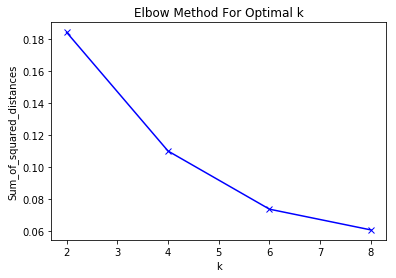

In [39]:

plt.plot(K, distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [40]:
# Train with optimal k number
clust_k = 6
kmeans = KMeans().setK(clust_k).setSeed(1)
cluster_model = kmeans.fit(userFactors)


In [41]:
# Get cluster centers Shows
centers = cluster_model.clusterCenters() # shape = (100,) On the reduced k dimensions matrix factor space
len(centers)

6

In [42]:
# Assign users to cluster groups
user_groups = cluster_model.transform(model.userFactors).select('id', 'prediction')\
                    .withColumnRenamed('prediction', 'user_group')


user_groups.show(5)


+---+----------+
| id|user_group|
+---+----------+
| 10|         5|
| 20|         3|
| 30|         0|
| 40|         1|
| 50|         1|
+---+----------+
only showing top 5 rows



In [43]:
# Add genders to ratings table
ratingsm = ratings.join(user_groups, ratings.userId == user_groups.id).join(movies, "movieId")
ratingsm.orderBy('userID').show(20)

+-------+------+------+---------+---+----------+--------------------+--------------------+
|movieId|userId|rating|timestamp| id|user_group|               title|              genres|
+-------+------+------+---------+---+----------+--------------------+--------------------+
|   3440|     1|   4.0|964981799|  1|         0|Teenage Mutant Ni...|Action|Adventure|...|
|   3617|     1|   4.0|964980683|  1|         0|    Road Trip (2000)|              Comedy|
|   3441|     1|   5.0|964982328|  1|         0|     Red Dawn (1984)|    Action|Drama|War|
|   3729|     1|   5.0|964982363|  1|         0|        Shaft (1971)|Action|Crime|Dram...|
|   3639|     1|   4.0|964982271|  1|         0|Man with the Gold...|Action|Adventure|...|
|   3489|     1|   4.0|964981775|  1|         0|         Hook (1991)|Adventure|Comedy|...|
|   3448|     1|   5.0|964984054|  1|         0|Good Morning, Vie...|    Comedy|Drama|War|
|   3809|     1|   4.0|964981220|  1|         0|What About Bob? (...|              Comedy|

In [44]:
# fit a CountVectorizerModel from the corpus to get genres as Bag of Words
from pyspark.ml.feature import CountVectorizer, RegexTokenizer
from pyspark.ml import Pipeline

tokenizer = RegexTokenizer(inputCol="genres", outputCol="tokens", pattern="\|")
cv = CountVectorizer(inputCol="tokens", outputCol="genres_vec", minDF=2.0)

pipeline = Pipeline(stages=[tokenizer, cv])

pipelineFit = pipeline.fit(ratingsm)
movies_cv = pipelineFit.transform(ratingsm)

columns_subset = [i  for i in movies_cv.columns if i not in ['timestam', 'title']]
movies_cv.select(columns_subset).orderBy("userId", ascending=False).show(10)


+-------+------+------+----------+---+----------+--------------------+--------------------+--------------------+
|movieId|userId|rating| timestamp| id|user_group|              genres|              tokens|          genres_vec|
+-------+------+------+----------+---+----------+--------------------+--------------------+--------------------+
| 163937|   610|   3.5|1493848789|610|         1|     Horror|Thriller|  [horror, thriller]|(20,[3,11],[1.0,1...|
| 166534|   610|   4.0|1493848402|610|         1|Drama|Horror|Thri...|[drama, horror, t...|(20,[0,3,11],[1.0...|
| 163981|   610|   3.5|1493850155|610|         1|              Horror|            [horror]|     (20,[11],[1.0])|
| 168252|   610|   5.0|1493846352|610|         1|       Action|Sci-Fi|    [action, sci-fi]|(20,[2,6],[1.0,1.0])|
| 168248|   610|   5.0|1493850091|610|         1|Action|Crime|Thri...|[action, crime, t...|(20,[2,3,7],[1.0,...|
| 166528|   610|   4.0|1493879365|610|         1|Action|Adventure|...|[action, adventur...|(20,[

+----------+-----+
|user_group|count|
+----------+-----+
|         0|31335|
|         1|28067|
|         2| 3311|
|         3|18742|
|         4| 5997|
|         5|13384|
+----------+-----+



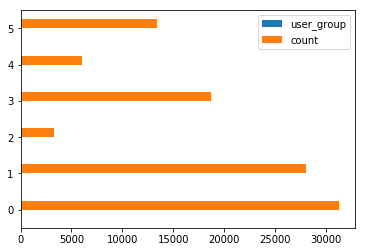

In [45]:
# Check group frequencies
group_counts = movies_cv.groupBy('user_group').count().orderBy('user_group')
group_counts.show()
fig, ax = plt.subplots()
group_counts.toPandas().plot.barh(ax=ax)
plt.show()

In [49]:
# Utility function to convert the rank values sparse matrix to dense 
from pyspark.sql import types as T
from pyspark.ml.linalg import SparseVector, DenseVector
def sparse_to_array(v):
  '''Convert pyspark.ml.linalg.SparseVector to array (which allows usual aggregations on it)'''
  v = DenseVector(v)  
  new_array = list([float(x) for x in v])
  return new_array

sparse_to_array_udf = F.udf(sparse_to_array, T.ArrayType(T.FloatType()))

#sum_vec_elems_udf = F.udf(lambda(x, T.ArrayType(T.FloatType()))

movies_cv_vec = movies_cv.select(['user_group', 'genres_vec'])\
                  .withColumn('genres_vec', sparse_to_array_udf('genres_vec'))\
                  #.groupBy('user_group').count()


In [51]:
total_genres = len(pipelineFit.stages[1].vocabulary)
groups_genres_pd = movies_cv_vec.groupBy('user_group').agg(*[F.sum(movies_cv_vec.genres_vec.getItem(i))\
                     .alias("v"+str(i)) for i in range(total_genres)]).toPandas()


In [52]:
groups_genres_pd.set_index('user_group', inplace=True)

groups_genres_pd.columns = list(pipelineFit.stages[1].vocabulary)
groups_genres_pd.sort_index().head(10)

,drama,comedy,action,thriller,adventure,romance,sci-fi,crime,fantasy,children,mystery,horror,animation,war,imax,musical,western,documentary,film-noir,(no genres listed)
user_group,,,,,,,,,,,,,,,,,,,,
0,12052.0,11976.0,10650.0,8579.0,8414.0,5134.0,6166.0,5301.0,4323.0,3196.0,2533.0,2416.0,2806.0,1312.0,1924.0,1216.0,459.0,432.0,168.0,25.0
1,14003.0,10205.0,6618.0,7205.0,4971.0,5324.0,3768.0,5011.0,2611.0,1678.0,2414.0,2101.0,1357.0,1531.0,625.0,987.0,549.0,500.0,418.0,10.0
2,1636.0,1409.0,668.0,737.0,528.0,856.0,344.0,507.0,293.0,203.0,262.0,277.0,132.0,164.0,40.0,135.0,57.0,25.0,47.0,0.0
3,7103.0,7048.0,6663.0,5304.0,5000.0,2927.0,3679.0,3171.0,2022.0,1770.0,1359.0,1254.0,1147.0,1024.0,655.0,819.0,490.0,105.0,164.0,4.0
4,2359.0,2502.0,1688.0,1420.0,1409.0,982.0,1137.0,877.0,809.0,536.0,406.0,554.0,406.0,248.0,242.0,239.0,79.0,113.0,41.0,3.0
5,4775.0,5913.0,4348.0,3207.0,3839.0,2901.0,2149.0,1814.0,1776.0,1825.0,700.0,689.0,1140.0,580.0,659.0,742.0,296.0,44.0,32.0,5.0


In [56]:
#groups_genres_pd.drop(['(no genres listed)'], axis=1, inplace=True)
groups_genres_pd.sort_index().head(10)


,drama,comedy,action,thriller,adventure,romance,sci-fi,crime,fantasy,children,mystery,horror,animation,war,imax,musical,western,documentary,film-noir
user_group,,,,,,,,,,,,,,,,,,,
0,12052.0,11976.0,10650.0,8579.0,8414.0,5134.0,6166.0,5301.0,4323.0,3196.0,2533.0,2416.0,2806.0,1312.0,1924.0,1216.0,459.0,432.0,168.0
1,14003.0,10205.0,6618.0,7205.0,4971.0,5324.0,3768.0,5011.0,2611.0,1678.0,2414.0,2101.0,1357.0,1531.0,625.0,987.0,549.0,500.0,418.0
2,1636.0,1409.0,668.0,737.0,528.0,856.0,344.0,507.0,293.0,203.0,262.0,277.0,132.0,164.0,40.0,135.0,57.0,25.0,47.0
3,7103.0,7048.0,6663.0,5304.0,5000.0,2927.0,3679.0,3171.0,2022.0,1770.0,1359.0,1254.0,1147.0,1024.0,655.0,819.0,490.0,105.0,164.0
4,2359.0,2502.0,1688.0,1420.0,1409.0,982.0,1137.0,877.0,809.0,536.0,406.0,554.0,406.0,248.0,242.0,239.0,79.0,113.0,41.0
5,4775.0,5913.0,4348.0,3207.0,3839.0,2901.0,2149.0,1814.0,1776.0,1825.0,700.0,689.0,1140.0,580.0,659.0,742.0,296.0,44.0,32.0


In [57]:
import prince
ca = prince.CA(
     n_components=2,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
     )

ca = ca.fit(groups_genres_pd)

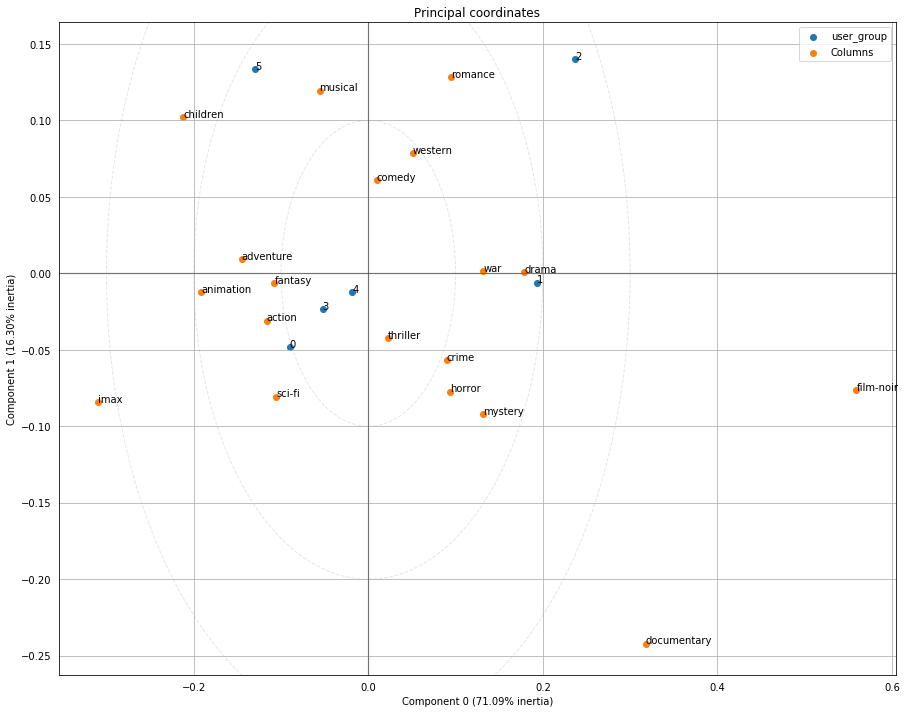

In [58]:
fig, ax1 = plt.subplots( figsize=(15,12) )
ca.plot_coordinates(
         X=groups_genres_pd,
         ax=ax1,
         figsize=(6, 6),
         x_component=0,
         y_component=1,
         show_row_labels=True,
         show_col_labels=True)
for radio in [.1,.2,.3]:
    ax1.add_artist( plt.Circle((0, 0), radio, linestyle = '--', color='gray', alpha=0.2, fill=False))
plt.show()